## Unrolled generative adversarial network demo
- double check architecture/hyperparams

In [4]:
%pylab inline
import tensorflow as tf
ds = tf.contrib.distributions
slim = tf.contrib.slim
graph_replace = tf.contrib.graph_editor.graph_replace

# NB: you need to install Keras
from keras.optimizers import Adam

Populating the interactive namespace from numpy and matplotlib


In [5]:
params = dict(
    batch_size=512,
    disc_learning_rate=1e-4,
    gen_learning_rate=1e-3,
    beta1=0.5,
    epsilon=1e-8,
    max_iter=1000,
    z_dim=256,
    x_dim=2,
    unrolling_steps=10,
)

In [6]:
from collections import OrderedDict
def extract_update_dict(update_ops):
    """Given a list of Assign and AssignAdd ops, compute updates in terms of differentiable ops.

    Args:
        update_ops: list of Assign and AssignAdd ops, typically computed using Keras' opt.get_updates()

    Returns:
        dict mappnig from variable values to their updated value
    """
    name_to_var = {v.name: v for v in tf.global_variables()}
    updates = OrderedDict()
    for update in update_ops:
        var_name = update.op.inputs[0].name
        var = name_to_var[var_name]
        value = update.op.inputs[1]
        if update.op.type == 'Assign':
            updates[var.value()] = value
        elif update.op.type == 'AssignAdd':
            updates[var.value()] = var + value
        else:
            raise ValueError("Update op type (%s) must be of type Assign or AssignAdd"%update_op.op.type)
    return updates

In [7]:
def generator(z, output_dim=2, n_hidden=128, n_layer=2):
    with tf.variable_scope("generator"):
        with slim.arg_scope([slim.fully_connected], normalizer_fn=None):
            h = slim.stack(z, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.tanh)
        x = slim.fully_connected(h, output_dim, activation_fn=None)
    return x

def discriminator(x, n_hidden=128, n_layer=2, reuse=False):
    with tf.variable_scope("discriminator", reuse=reuse):
        with slim.arg_scope([slim.fully_connected], normalizer_fn=None):#, init):#slim.batch_norm):
            h = slim.stack(x, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.tanh)
        log_d = slim.fully_connected(h, 1, activation_fn=None)
    return log_d

In [8]:
def sample_mog(batch_size, n_mixture=8, std=0.01):
    thetas = np.linspace(0, 2 * np.pi, n_mixture)
    xs, ys = np.sin(thetas), np.cos(thetas)
    cat = ds.Categorical(tf.zeros(n_mixture))
    comps = [ds.MultivariateNormalDiag([xi, yi], [std, std]) for xi, yi in zip(xs.ravel(), ys.ravel())]
    data = ds.Mixture(cat, comps)
    return data.sample_n(batch_size)

In [9]:
tf.reset_default_graph()

In [10]:
noise = ds.Normal(tf.zeros(params['z_dim']), 
                      tf.ones(params['z_dim'])).sample_n(params['batch_size'])
with slim.arg_scope([slim.fully_connected]):#, weights_initializer=tf.orthogonal_initializer(gain=0.8)):
    samples = generator(noise, output_dim=params['x_dim'])
    data = sample_mog(params['batch_size'])

    real_score = discriminator(data)
    fake_score = discriminator(samples, reuse=True)

In [11]:
loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(real_score, tf.ones_like(real_score)) +
        tf.nn.sigmoid_cross_entropy_with_logits(fake_score, tf.zeros_like(fake_score)))

In [12]:
gen_vars = tf.contrib.framework.get_variables(scope="generator")
disc_vars = tf.contrib.framework.get_variables(scope="discriminator")

# TODO: grab variables in a smarter way so I don't need this
gen_vars = filter(lambda v:'BatchNorm' not in v.name, gen_vars)
disc_vars = filter(lambda v:'BatchNorm' not in v.name, disc_vars)

In [13]:
d_opt = Adam(lr=params['disc_learning_rate'], beta_1=params['beta1'], epsilon=params['epsilon'])
updates = d_opt.get_updates(disc_vars, [], loss)

In [14]:
update_dict = extract_update_dict(updates)

In [15]:
d_train_op = tf.group(*updates, name="d_train_op")

In [16]:
cur_update_dict = update_dict
for i in xrange(params['unrolling_steps']):
    new_values = graph_replace(update_dict.values(), cur_update_dict)
    cur_update_dict = OrderedDict(zip(update_dict.keys(), new_values))

In [17]:
#cur_update_dict = {k:k for k, v in update_dict.iteritems()}
unrolled_loss = graph_replace(loss, cur_update_dict)

In [18]:
def unroll_minimize(opt, loss, vars, num_iter=5, eta=0.001):
    cur_vars = vars
    cur_grads = grads = tf.gradients(loss, vars)
    opt_state = {'rms': {p: opt.get_slot(p, 'rms') for p in disc_vars}}
    for ii in xrange(num_iter):
        if ii > 0:
            [cur_loss, cur_grads] = graph_replace([loss, grads], updates) 
            cur_vars = updates.values()
        else:
            cur_loss = loss
        updates, opt_state = compute_rmsprop_updates(opt_state, vars, cur_vars, cur_grads, eta)
    return cur_loss, updates

In [19]:
#unrolled_loss, updates = unroll_minimize(d_opt, loss, disc_vars, num_iter=10, eta=params['disc_learning_rate']/1.0)

In [20]:
g_train_op = tf.train.AdamOptimizer(params['gen_learning_rate'], beta1=params['beta1'], epsilon=params['epsilon']).minimize(-unrolled_loss, var_list=gen_vars)
#g_train_op = tf.train.RMSPropOptimizer(params['gen_learning_rate']).minimize(-unrolled_loss, var_list=gen_vars)

In [21]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [22]:
grad_unrolled = tf.gradients(unrolled_loss, gen_vars)

In [23]:
map(lambda x: np.any(np.isnan(x)), sess.run(cur_update_dict).values())

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [24]:
sess.run(g_train_op)

In [25]:
sess.run(unrolled_loss)

1.3786418

In [26]:
sess.run(samples)

array([[ 0.57544386, -0.42788503],
       [ 0.49156561, -1.99849856],
       [-0.1514575 ,  0.26313555],
       ..., 
       [ 0.91053718,  1.07786679],
       [-1.65941536, -0.85537964],
       [-0.10975221,  0.08983675]], dtype=float32)

In [27]:
import seaborn as sns

In [28]:
#frames_unrolled = frames

  0%|          | 0/15000 [00:00<?, ?it/s]

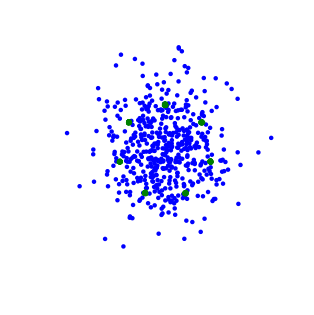

  3%|▎         | 500/15000 [00:39<17:29, 13.81it/s]

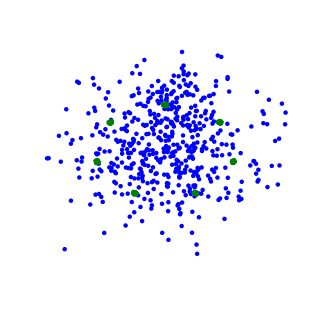

  7%|▋         | 1000/15000 [01:17<16:27, 14.17it/s]

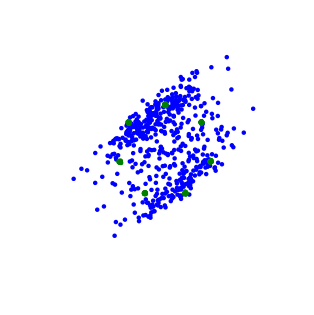

 10%|█         | 1500/15000 [01:55<15:47, 14.25it/s]

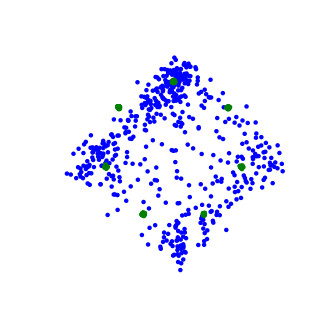

 13%|█▎        | 2000/15000 [02:33<15:12, 14.25it/s]

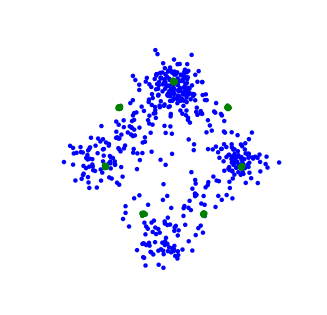

 17%|█▋        | 2500/15000 [03:12<15:35, 13.36it/s]

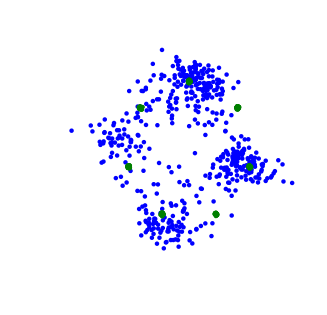

 20%|██        | 3000/15000 [03:51<14:41, 13.62it/s]

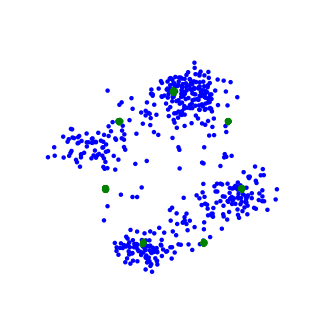

 23%|██▎       | 3500/15000 [04:31<13:59, 13.70it/s]

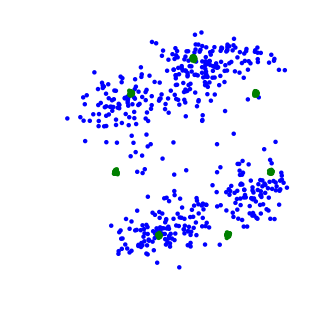

 27%|██▋       | 4000/15000 [05:11<14:12, 12.90it/s]

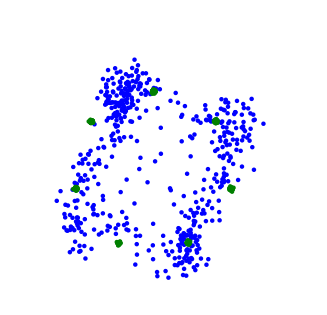

 30%|███       | 4500/15000 [05:51<13:16, 13.18it/s]

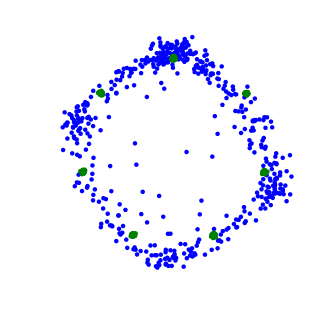

 33%|███▎      | 5000/15000 [06:31<12:13, 13.64it/s]

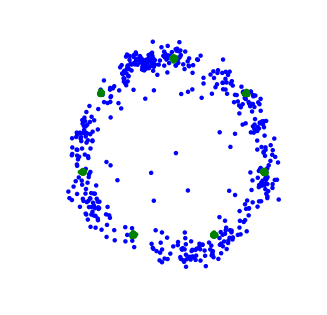

 37%|███▋      | 5500/15000 [07:11<11:44, 13.49it/s]

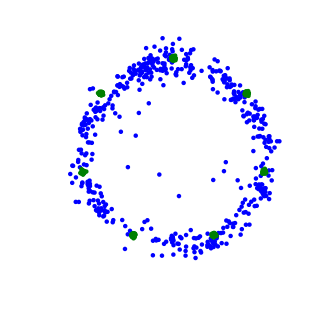

 40%|████      | 6000/15000 [07:51<11:09, 13.44it/s]

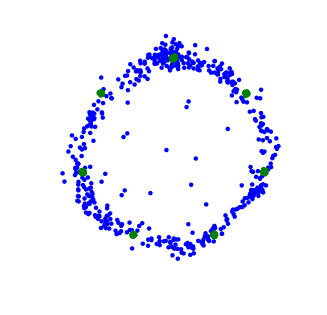

 42%|████▏     | 6238/15000 [08:10<11:35, 12.59it/s]

In [ ]:
from tqdm import tqdm
fs = []
frames = []
from moviepy.video.io.bindings import mplfig_to_npimage

fig = figure(figsize=(5,5))
for i in tqdm(xrange(15000)):
    f, _, _ = sess.run([[loss, unrolled_loss], g_train_op, d_train_op])
    fs.append(f)
    if i % 5 == 0:
        xx, yy = sess.run([samples, data])
        clf()
        scatter(xx[:, 0], xx[:, 1], edgecolor='none')
        scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none')

        #xlim(-2, 2)
        #ylim(-2, 2)
        axis('off')
        draw()
        frames.append(mplfig_to_npimage(fig))
        if i % 500 == 0:
            show()
            fig = figure(figsize=(5,5))


In [ ]:
np_loss, np_unrolled = np.array(fs).T
plot(np_loss-np_unrolled)

In [ ]:
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

In [ ]:
clip = mpy.ImageSequenceClip(frames[::], fps=30)

In [ ]:
clip.ipython_display()#max_duration=200)

In [ ]:
semilogy(fs)
legend(('loss', 'unrolled loss'))